In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.options.display.float_format = '{:.4f}'.format

In [73]:
# Parameters of the strategy
aum = 10_000_000
initial_price = 5

arbitrage_probability_buy_coinbase_sell_binance = 0.57
arbitrage_probability_buy_binance_sell_coinbase = 0.43

trade_fee_binance = 0.00022
trade_fee_coinbase = 0.00017
standard_profit = 0.016
usd_usdt_rate = 1.0012

trade_size_usdt = 500
trade_size_usd = trade_size_usdt * usd_usdt_rate

withdrawal_fee_dd_binance_to_coinbase = 45
withdrawal_fee_dd_coinbase_to_binance = 62
withdrawal_fee_usd_binance_to_coinbase = 3
withdrawal_fee_usd_coinbase_to_binance = 4
loan_interest_daily_binance = 0.03
hourly_fluctuation_range = 0.05
max_daily_increase = 0.60
max_daily_decrease = 0.25
volume_binance = 100_000_000
volume_coinbase = 80_000_000
dominance_binance = 0.026
dominance_coinbase = 0.041
special_hour_profit = 0.10
special_hour = 17


# Simulation parameters
days = 100
hours_per_day = 24

In [74]:
# Initialize DataFrame to store hourly data
columns = [
    'day', 'hour', 'price', 'price_change', 'fees_binance', 'fees_coinbase', 'volume', "profit",
    'balance_binance_usdt', 'DOUBLEDOGE_binance', 'balance_coinbase_usd', 'DOUBLEDOGE_coinbase', 'trade_direction']
data = []

# Initial balances
balance_coinbase_usd = aum / 2 * 0.57  / usd_usdt_rate
DOUBLEDOGE_coinbase = (aum / 2 * 0.43) / initial_price
balance_binance_usdt = aum / 2 * 0.43
DOUBLEDOGE_binance = (aum / 2 * 0.57) / initial_price

# Simulation loop for 10 days
for day in range(1, days+1):
    prices = [initial_price]
    profit_per_trade = standard_profit
    daily_profits = 0
    total_trades_binance = 0
    total_trades_coinbase = 0
    cumulative_daily_change = 0
    cumulative_daily_volume = 0
    
    buying_backlash = -0.008
    selling_backlash = 0.00788


    # Simulate hourly price fluctuation
    for hour in range(1, hours_per_day+1):
        # Calculate the remaining allowed change for the day
        remaining_increase = max_daily_increase - cumulative_daily_change
        remaining_decrease = max_daily_decrease + cumulative_daily_change

        # Adjust the range for the hourly fluctuation
        lower_bound = max(-hourly_fluctuation_range, -remaining_decrease)
        upper_bound = min(hourly_fluctuation_range, remaining_increase)
        change = np.random.uniform(lower_bound, upper_bound)

        # Calculate the new price
        new_price = prices[-1] * (1 + change)
        prices.append(new_price)
        current_price = new_price

        arbitrage_direction = np.random.choice(['buy_coinbase_sell_binance', 'buy_binance_sell_coinbase'], 
                                               p=[arbitrage_probability_buy_coinbase_sell_binance, arbitrage_probability_buy_binance_sell_coinbase])
        trade_direction = None
        
        # Special hour condition
        if hour == special_hour:
            buying_backlash = -0.05
            selling_backlash = 0.05
        else:
            buying_backlash = -0.008
            selling_backlash = 0.00788


        if arbitrage_direction == "buy_coinbase_sell_binance":
            # Buy on Coinbase, sell on Binance
            # Base parameters of trade
            buy_price_coinbase = current_price * (1 + buying_backlash) 
            bought_volume = trade_size_usd * (1 - trade_fee_coinbase) / buy_price_coinbase
            sell_price_binance = current_price * (1 + selling_backlash)
            sold_volume = bought_volume * (1 - trade_fee_binance)
            
            buying_fee = trade_size_usd * trade_fee_coinbase
            selling_fee = bought_volume * sell_price_binance * trade_fee_binance
        
            # Update balances after trade
            balance_coinbase_usd -= trade_size_usd
            DOUBLEDOGE_coinbase += bought_volume
            balance_binance_usdt += sold_volume * sell_price_binance
            DOUBLEDOGE_binance -= sold_volume
            volume = bought_volume * 2
            
            trade_direction = 'coinbase_to_binance'

        elif arbitrage_direction == "buy_binance_sell_coinbase":
            # Buy on Binance, sell on Coinbase    
            # Base parameters of trade
            buy_price_binance = current_price * (1 + buying_backlash)  
            bought_volume = trade_size_usdt * (1 - trade_fee_binance) / buy_price_binance
            sell_price_coinbase = current_price * (1 + selling_backlash)
            sold_volume = bought_volume * (1 - trade_fee_coinbase)
            
            buying_fee = trade_size_usdt * trade_fee_binance
            selling_fee = bought_volume * sell_price_coinbase * trade_fee_coinbase
        
            # Update balances after trade
            balance_binance_usdt -= trade_size_usdt
            DOUBLEDOGE_binance += bought_volume
            balance_coinbase_usd += sold_volume * sell_price_coinbase
            DOUBLEDOGE_coinbase -= sold_volume
            volume = bought_volume * 2

            trade_direction = 'binance_to_coinbase'
        
        # Calculate profit
        if trade_direction == 'coinbase_to_binance':
            profit = (sold_volume * sell_price_binance - trade_size_usd) - buying_fee - selling_fee
        elif trade_direction == 'binance_to_coinbase':
            profit = (sold_volume * sell_price_coinbase - trade_size_usdt) - buying_fee - selling_fee

        
        # Record hourly data
        data.append([
            day, hour, current_price, change, buying_fee, selling_fee, volume, profit, 
            balance_binance_usdt, DOUBLEDOGE_binance, balance_coinbase_usd, DOUBLEDOGE_coinbase, trade_direction
        ])

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

In [76]:
## 1. How much volume would you expect to trade in a day?
## Statistics to anser the question
volume_research = df.copy()
volume_research["vol_in_usd"] = volume_research["volume"] * volume_research["price"]
volume_groupped = volume_research.groupby("day").sum()

volume_research["vol_in_usd"] = volume_research["volume"] * volume_research["price"]
volume_groupped = volume_research.groupby("day").sum()
volume_groupped.describe()

,hour,price,price_change,fees_binance,fees_coinbase,volume,profit,balance_binance_usdt,DOUBLEDOGE_binance,balance_coinbase_usd,DOUBLEDOGE_coinbase,vol_in_usd
count,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
mean,300.0000,119.9547,-0.0020,2.2894,2.4407,4898.3746,227.3874,54217621.6204,13166576.9796,65978852.5692,10834012.6252,24250.5566
std,0.0000,9.5173,0.1384,0.0671,0.0689,407.4937,0.0353,1499826.3807,289652.4357,1339603.4813,289988.5272,3.3977
min,300.0000,96.0676,-0.3987,2.1171,2.2608,4124.0475,227.3025,51663132.9370,12651057.9353,63537027.2574,10331944.9190,24241.6579
25%,300.0000,114.0869,-0.1044,2.2416,2.4117,4631.1131,227.3549,53063417.6110,12966175.7980,65098600.6017,10612464.4618,24249.1614
50%,300.0000,121.0362,0.0082,2.2914,2.4395,4817.6800,227.3975,54036619.4989,13200931.2362,66155164.1559,10799640.1570,24250.4770
75%,300.0000,125.8038,0.1004,2.3163,2.4883,5108.3309,227.4149,55235747.6237,13387835.1288,66993789.6728,11034703.2722,24252.9411
max,300.0000,141.8050,0.3233,2.4657,2.6160,6156.2057,227.4586,56918492.7705,13668061.0988,68257586.5057,11350071.9862,24259.2404


In [101]:
## 2. What should the optimal balances be for DOUBLEDOGE_coinbase, DOUBLEDOGE_binance, USD, USDT?

mean_daily_volume = volume_groupped["volume"].mean() 
maximum_daily_volume = volume_groupped["volume"].max()
daily_volume_std = volume_groupped["volume"].std()  
(maximum_daily_volume - mean_daily_volume) / daily_volume_std         

volume_30_days = round(maximum_daily_volume * 30, 2)
DOUBLEDOGE_coinbase = round(volume_30_days *  0.43, 2 )
DOUBLEDOGE_binance = round(volume_30_days * 0.57, 2)

maximum_daily_volume = round(volume_groupped["vol_in_usd"].max(), 2)
volume_30_days_usd = round(maximum_daily_volume * 30, 2)

USDT_binance = round(volume_30_days_usd *  0.43, 2) 
USD_coinbase = round(volume_30_days_usd * 0.57, 2)

print(f"Cumulative vol. DD in 30 days {volume_30_days},\nAmount DoubeDoge for coinbase: {DOUBLEDOGE_coinbase}\nAmount DoubeDoge for Binance: {DOUBLEDOGE_binance}\n ")
print(f"Cumulative vol. USD in 30 days {volume_30_days_usd},\nAmount USD for conbase: {USD_coinbase}\nAmount USDT for Binance: {USDT_binance}\n ")


Cumulative vol. DD in 30 days 184686.17,
Amount DoubeDoge for coinbase: 79415.05
Amount DoubeDoge for Binance: 105271.12
 
Cumulative vol. USD in 30 days 727777.2,
Amount USD for conbase: 414833.0
Amount USDT for Binance: 312944.2
 


In [ ]:
## 4. At what point would you want to make a transfer between exchanges?
## Furher part consist calculations of possible rebalancing scenarios. 
## I've encountered an error which I was not able to solve shortly due to the lack of time 
## so the calulations provided in the other file has a simplified, yet effective, approach to answer this question.

In [8]:
withdrawal_fee_dd_binance_to_coinbase = 45
withdrawal_fee_dd_coinbase_to_binance = 62
withdrawal_fee_usd_binance_to_coinbase = 3
withdrawal_fee_usd_coinbase_to_binance = 4

print((withdrawal_fee_dd_binance_to_coinbase + withdrawal_fee_dd_coinbase_to_binance + withdrawal_fee_usd_binance_to_coinbase + withdrawal_fee_usd_coinbase_to_binance))

114


In [10]:
df_balance_change = df.copy()
df_balance_change["balance_binance_usdt_%"] = df_balance_change["balance_binance_usdt"].pct_change() * 100
df_balance_change["DOUBLEDOGE_binance_%"] = df_balance_change["DOUBLEDOGE_binance"].pct_change() * 100
df_balance_change["balance_coinbase_usd_%"] = df_balance_change["balance_coinbase_usd"].pct_change() * 100
df_balance_change["DOUBLEDOGE_coinbase_%"] = df_balance_change["DOUBLEDOGE_coinbase"].pct_change() * 100
df_balance_change["DOUBLEDOGE_total"] = df_balance_change["DOUBLEDOGE_coinbase"] + df_balance_change["DOUBLEDOGE_binance"]
df_balance_change["usdt_total"] = df_balance_change["balance_binance_usdt"] + (df_balance_change["balance_coinbase_usd"])
df_balance_change["balance_total"] = df_balance_change["usdt_total"] + (df_balance_change["DOUBLEDOGE_total"] * df_balance_change["price"])


df_balance_change.describe()

,day,hour,price,price_change,fees_binance,fees_coinbase,volume,profit,balance_binance_usdt,DOUBLEDOGE_binance,balance_coinbase_usd,DOUBLEDOGE_coinbase,balance_binance_usdt_%,DOUBLEDOGE_binance_%,balance_coinbase_usd_%,DOUBLEDOGE_coinbase_%,DOUBLEDOGE_total,usdt_total,balance_total
count,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2400.0000,2399.0000,2399.0000,2399.0000,2399.0000,2400.0000,2400.0000,2400.0000
mean,50.5000,12.5000,5.0194,-0.0000,0.0962,0.1009,203.3921,9.4742,2219533.4501,556847.0273,2788652.5587,443177.2537,0.0027,-0.0020,-0.0018,0.0026,1000024.2810,5008186.0088,10027689.6141
std,28.8721,6.9236,0.5127,0.0288,0.0124,0.0129,20.8468,8.9213,39945.1095,7423.3080,33346.8553,7437.0761,0.0226,0.0182,0.0180,0.0229,13.9792,6701.8706,513498.9296
min,1.0000,1.0000,3.5278,-0.0500,0.0851,0.0863,141.8340,7.6096,2147746.6308,542421.8705,2722045.6489,429569.4628,-0.0233,-0.0256,-0.0184,-0.0321,1000000.0225,4996591.9144,8536967.8394
25%,25.7500,6.7500,4.6843,-0.0245,0.0851,0.0863,190.1322,7.6096,2191936.9314,550551.7876,2761576.3202,438240.6630,-0.0226,-0.0183,-0.0179,-0.0224,1000012.1924,5002392.7410,9692088.1490
50%,50.5000,12.5000,5.0017,-0.0012,0.0851,0.1119,201.8026,7.6183,2209018.6152,559008.7245,2799064.9256,441015.3896,0.0223,-0.0161,-0.0177,0.0201,1000024.2163,5008193.3288,10010589.5147
75%,75.2500,18.2500,5.3112,0.0248,0.1100,0.1119,215.7459,7.6183,2252365.7718,561771.4334,2810708.7164,449484.1314,0.0231,0.0178,0.0181,0.0231,1000036.4341,5013994.1230,10321694.5624
max,100.0000,24.0000,7.1058,0.0500,0.1100,0.1217,286.0465,52.2722,2297343.6785,570431.5395,2849340.6812,457625.4835,0.0257,0.0256,0.0202,0.0324,1000048.2761,5019795.2477,12119572.5698


In [11]:
df_balance_change[df_balance_change["trade_direction"] == "binance_to_coinbase"].groupby("day").sum()

,hour,price,price_change,fees_binance,fees_coinbase,volume,profit,balance_binance_usdt,DOUBLEDOGE_binance,balance_coinbase_usd,DOUBLEDOGE_coinbase,trade_direction,balance_binance_usdt_%,DOUBLEDOGE_binance_%,balance_coinbase_usd_%,DOUBLEDOGE_coinbase_%,DOUBLEDOGE_total,usdt_total,balance_total
day,,,,,,,,,,,,,,,,,,,
1,138,50.7273,0.0312,1.1000,0.8634,1989.5810,76.0959,21514832.4607,5697202.3920,28452220.5169,4302800.3596,binance_to_coinbasebinance_to_coinbasebinance_...,-0.2323,0.1746,0.1785,-0.2311,10000002.7516,49967052.9776,100694406.4749
2,192,78.7622,-0.1684,1.6500,1.3027,2906.9456,158.7464,32259043.0688,8548401.7564,42694922.9379,6451608.7984,binance_to_coinbasebinance_to_coinbasebinance_...,-0.3487,0.2551,0.2692,-0.3378,15000010.5548,74953966.0068,153716195.3372
3,79,41.5436,0.0467,0.8800,0.6907,1559.6928,60.8767,17197856.9091,4560246.7219,22779235.6732,3439762.1908,binance_to_coinbasebinance_to_coinbasebinance_...,-0.1860,0.1368,0.1427,-0.1813,8000008.9127,39977092.5823,81520760.2261
4,137,47.2872,0.0825,1.1000,0.8710,2144.7890,120.6984,21548365.2936,5689659.1960,28425643.0056,4310357.9453,binance_to_coinbasebinance_to_coinbasebinance_...,-0.2320,0.1885,0.1802,-0.2487,10000017.1413,49974008.2992,97261338.9143
5,126,65.2743,0.0551,1.2100,0.9498,1885.1248,83.7055,23708482.9641,6257693.1949,31265228.1092,4742330.2574,binance_to_coinbasebinance_to_coinbasebinance_...,-0.2551,0.1657,0.1966,-0.2186,11000023.4523,54973711.0732,120248133.8668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,77,39.6511,-0.1303,0.8800,0.6983,1641.9186,105.4793,18293311.7504,4356762.6088,21856411.3004,3643605.6640,binance_to_coinbasebinance_to_coinbasebinance_...,-0.1749,0.1508,0.1504,-0.1802,8000368.2728,40149723.0508,79802621.6538
97,124,57.1820,0.0535,1.2100,0.9498,2135.3811,83.7055,25191494.9149,5982189.0170,30017141.5553,5018323.3070,binance_to_coinbasebinance_to_coinbasebinance_...,-0.2401,0.1964,0.2047,-0.2339,11000512.3241,55208636.4703,112393257.5968
98,67,34.5161,-0.1409,0.7700,0.6044,1431.8605,53.2671,16047007.5304,3803928.6712,19087207.8179,3196400.4281,binance_to_coinbasebinance_to_coinbasebinance_...,-0.1526,0.1318,0.1304,-0.1567,7000329.0993,35134215.3483,69651946.8259


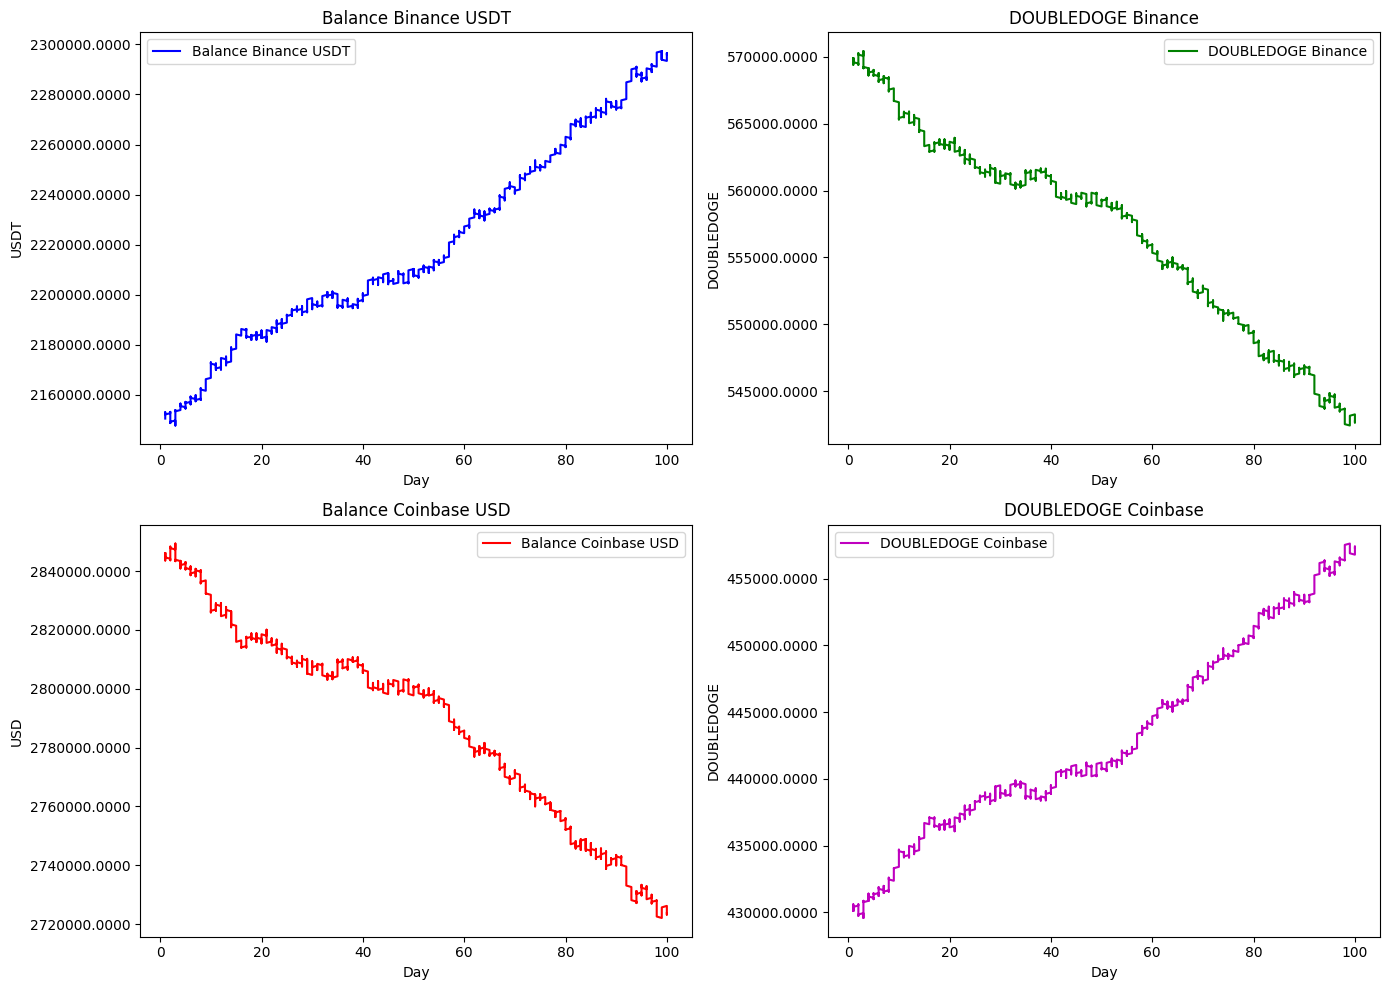

In [13]:
# Function to format y-axis to plain format
def format_axes(ax):
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.4f}'.format(x)))

# Plot the specified columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot balance_binance_usdt
axs[0, 0].plot(df['day'], df['balance_binance_usdt'], linestyle='-', color='b', label='Balance Binance USDT')
axs[0, 0].set_title('Balance Binance USDT')
axs[0, 0].set_xlabel('Day')
axs[0, 0].set_ylabel('USDT')
axs[0, 0].legend()
format_axes(axs[0, 0])

# Plot DOUBLEDOGE_binance
axs[0, 1].plot(df['day'], df['DOUBLEDOGE_binance'], linestyle='-', color='g', label='DOUBLEDOGE Binance')
axs[0, 1].set_title('DOUBLEDOGE Binance')
axs[0, 1].set_xlabel('Day')
axs[0, 1].set_ylabel('DOUBLEDOGE')
axs[0, 1].legend()
format_axes(axs[0, 1])

# Plot balance_coinbase_usd
axs[1, 0].plot(df['day'], df['balance_coinbase_usd'], linestyle='-', color='r', label='Balance Coinbase USD')
axs[1, 0].set_title('Balance Coinbase USD')
axs[1, 0].set_xlabel('Day')
axs[1, 0].set_ylabel('USD')
axs[1, 0].legend()
format_axes(axs[1, 0])

# Plot DOUBLEDOGE_coinbase
axs[1, 1].plot(df['day'], df['DOUBLEDOGE_coinbase'], linestyle='-', color='m', label='DOUBLEDOGE Coinbase')
axs[1, 1].set_title('DOUBLEDOGE Coinbase')
axs[1, 1].set_xlabel('Day')
axs[1, 1].set_ylabel('DOUBLEDOGE')
axs[1, 1].legend()
format_axes(axs[1, 1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [5]:
# Initialize DataFrame to store hourly data
columns = [
    'day', 'hour', 'price', 'price_change', 'fees_binance', 'fees_coinbase', 'volume', "profit",
    'balance_binance_usdt', 'DOUBLEDOGE_binance', 'balance_coinbase_usd', 'DOUBLEDOGE_coinbase', 'trade_direction', "diff_coinbase_usd_balance", "diff_balance_usdt_binance", "diff_DOUBLEDOGE_coinbase", "diff_DOUBLEDOGE_binance"]
data = []

# Initial balances
balance_coinbase_usd = aum / 2 * 0.57  / usd_usdt_rate
DOUBLEDOGE_coinbase = (aum / 2 * 0.43) / initial_price
balance_binance_usdt = aum / 2 * 0.43
DOUBLEDOGE_binance = (aum / 2 * 0.57) / initial_price

balance_usd_total = balance_coinbase_usd + balance_binance_usdt
balance_DOUBLEDOGE_total = DOUBLEDOGE_coinbase + DOUBLEDOGE_binance

rebalance_usdt_from_binance = 0
rebalance_usd_from_coinbase = 0
rebalance_DOUBLEDOGE_from_coinbase = 0
rebalance_DOUBLEDOGE_from_binance = 0

DOUBLEDOGE_from_coinbase_started = False
DOUBLEDOGE_from_binance_started = False


# Simulation loop for 10 days
for day in range(1, days+1):
    prices = [initial_price]
    profit_per_trade = standard_profit
    daily_profits = 0
    total_trades_binance = 0
    total_trades_coinbase = 0
    cumulative_daily_change = 0
    cumulative_daily_volume = 0
    
    buying_backlash = -0.008
    selling_backlash = 0.00788


    # Simulate hourly price fluctuation
    for hour in range(1, hours_per_day+1):
        # Calculate the remaining allowed change for the day
        remaining_increase = max_daily_increase - cumulative_daily_change
        remaining_decrease = max_daily_decrease + cumulative_daily_change

        # Adjust the range for the hourly fluctuation
        lower_bound = max(-hourly_fluctuation_range, -remaining_decrease)
        upper_bound = min(hourly_fluctuation_range, remaining_increase)
        change = np.random.uniform(lower_bound, upper_bound)

        # Update the cumulative daily change
        cumulative_daily_change += change

        # Calculate the new price
        new_price = prices[-1] * (1 + change)
        prices.append(new_price)
        current_price = new_price

        arbitrage_direction = np.random.choice(['buy_coinbase_sell_binance', 'buy_binance_sell_coinbase'], 
                                               p=[arbitrage_probability_buy_coinbase_sell_binance, arbitrage_probability_buy_binance_sell_coinbase])
        trade_direction = None
        
        # Special hour condition
        if hour == special_hour:
            buying_backlash = -0.05
            selling_backlash = 0.05
        else:
            buying_backlash = -0.008
            selling_backlash = 0.00788


        if arbitrage_direction == "buy_coinbase_sell_binance":
            # Buy on Coinbase, sell on Binance
            # Base parameters of trade
            buy_price_coinbase = current_price * (1 + buying_backlash) 
            bought_volume = trade_size_usd * (1 - trade_fee_coinbase) / buy_price_coinbase
            sell_price_binance = current_price * (1 + selling_backlash)
            sold_volume = bought_volume * (1 - trade_fee_binance)
            
            buying_fee = trade_size_usd * trade_fee_coinbase
            selling_fee = bought_volume * sell_price_binance * trade_fee_binance
        
            # Update balances after trade
            balance_coinbase_usd -= trade_size_usd
            DOUBLEDOGE_coinbase += bought_volume
            balance_binance_usdt += sold_volume * sell_price_binance
            DOUBLEDOGE_binance -= sold_volume
            volume = bought_volume * 2
            
            trade_direction = 'coinbase_to_binance'

        elif arbitrage_direction == "buy_binance_sell_coinbase":
            # Buy on Binance, sell on Coinbase    
            # Base parameters of trade
            buy_price_binance = current_price * (1 + buying_backlash)  
            bought_volume = trade_size_usdt * (1 - trade_fee_binance) / buy_price_binance
            sell_price_coinbase = current_price * (1 + selling_backlash)
            sold_volume = bought_volume * (1 - trade_fee_coinbase)
            
            buying_fee = trade_size_usdt * trade_fee_binance
            selling_fee = bought_volume * sell_price_coinbase * trade_fee_coinbase
        
            # Update balances after trade
            balance_binance_usdt -= trade_size_usdt
            DOUBLEDOGE_binance += bought_volume
            balance_coinbase_usd += sold_volume * sell_price_coinbase
            DOUBLEDOGE_coinbase -= sold_volume
            volume = bought_volume * 2

            trade_direction = 'binance_to_coinbase'
        
        # Calculate profit
        if trade_direction == 'coinbase_to_binance':
            profit = (sold_volume * sell_price_binance - trade_size_usd) - buying_fee - selling_fee
        elif trade_direction == 'binance_to_coinbase':
            profit = (sold_volume * sell_price_coinbase - trade_size_usdt) - buying_fee - selling_fee

        balance_usdt_total = (balance_coinbase_usd / usd_usdt_rate) + balance_binance_usdt
        balance_DOUBLEDOGE_total = DOUBLEDOGE_coinbase + DOUBLEDOGE_binance
                
        desired_coinbase_usd_balance =  balance_usdt_total * 0.57
        desired_binance_usdt_balance = balance_usdt_total * 0.43
        desired_DOUBLEDOGE_coinbase = balance_DOUBLEDOGE_total * 0.43
        desired_DOUBLEDOGE_binance = balance_DOUBLEDOGE_total * 0.57
            
    
        diff_coinbase_usd_balance = desired_coinbase_usd_balance - balance_coinbase_usd
        diff_balance_usdt_binance = desired_binance_usdt_balance - balance_binance_usdt
        diff_DOUBLEDOGE_coinbase = desired_DOUBLEDOGE_coinbase - DOUBLEDOGE_coinbase
        diff_DOUBLEDOGE_binance = desired_DOUBLEDOGE_binance - DOUBLEDOGE_binance

        # Record hourly data
        data.append([
            day, hour, current_price, change, buying_fee, selling_fee, volume, profit, 
            balance_binance_usdt, DOUBLEDOGE_binance, balance_coinbase_usd, DOUBLEDOGE_coinbase, trade_direction, diff_coinbase_usd_balance, diff_balance_usdt_binance, diff_DOUBLEDOGE_coinbase, diff_DOUBLEDOGE_binance])
        
        if hour == 23:
            # Rebalance
            balance_usdt_total = (balance_coinbase_usd / usd_usdt_rate) + balance_binance_usdt
            balance_DOUBLEDOGE_total = DOUBLEDOGE_coinbase + DOUBLEDOGE_binance
            
            desired_coinbase_usd_balance =  balance_usdt_total * 0.57
            desired_binance_usdt_balance = balance_usdt_total * 0.43
            desired_DOUBLEDOGE_coinbase = balance_DOUBLEDOGE_total * 0.43
            desired_DOUBLEDOGE_binance = balance_DOUBLEDOGE_total * 0.57
        
            diff_coinbase_usd_balance = desired_coinbase_usd_balance - balance_coinbase_usd
            diff_balance_usdt_binance = desired_binance_usdt_balance - balance_binance_usdt
            diff_DOUBLEDOGE_coinbase = desired_DOUBLEDOGE_coinbase - DOUBLEDOGE_coinbase
            diff_DOUBLEDOGE_binance = desired_DOUBLEDOGE_binance - DOUBLEDOGE_binance

        #     print(f"diff_coinbase_usd_balance {diff_coinbase_usd_balance}, diff_balance_usdt_binance {diff_balance_usdt_binance}, diff_DOUBLEDOGE_coinbase {diff_DOUBLEDOGE_coinbase}, diff_DOUBLEDOGE_binance {diff_DOUBLEDOGE_binance}")

        #     # Transfering USD from Coinbase to binance
        #     if diff_coinbase_usd_balance >=  220:
        #         print("condition 1")
        #         transfer_value = diff_coinbase_usd_balance * usd_usdt_rate
        #         balance_binance_usdt -= transfer_value - withdrawal_fee_usd_binance_to_coinbase
        #         balance_coinbase_usd += transfer_value
        #         rebalance_usdt_from_binance += 1
                
        #     # Transfering USDT from Binance to Coinbase
        #     if diff_balance_usdt_binance <= -220:
        #         # print("condition 2")
        #         transfer_value = (diff_balance_usdt_binance / usd_usdt_rate)
        #         balance_binance_usdt += transfer_value - withdrawal_fee_usd_coinbase_to_binance
        #         balance_coinbase_usd -= transfer_value
        #         rebalance_usd_from_coinbase += 1
    
        #     # Sell DOUBLEDOGE at coinbase and start transfer to binance
        #     if diff_DOUBLEDOGE_coinbase <= -20:
        #         print("condition 3", "diff_DOUBLEDOGE_coinbase:",diff_DOUBLEDOGE_coinbase, "diff_DOUBLEDOGE_binance:", diff_DOUBLEDOGE_binance)
        #         DOUBLEDOGE_coinbase -= diff_DOUBLEDOGE_coinbase
        #         convert_dd_to_usd_from_coinbase = diff_DOUBLEDOGE_coinbase * current_price * usd_usdt_rate
        #         DOUBLEDOGE_from_coinbase_started = True
        #         print(f"day{day},hour {hour}, diff_DOUBLEDOGE_coinbase {diff_DOUBLEDOGE_coinbase}, convert_dd_to_usd {convert_dd_to_usd_from_coinbase}, current_price {current_price}")

        #     # Sell DOUBLEDOGE at binance and start transfer to coinbase
        #     if diff_DOUBLEDOGE_binance >= 20:
        #         print("condition 4", "diff_DOUBLEDOGE_coinbase:",diff_DOUBLEDOGE_coinbase, "diff_DOUBLEDOGE_binance:", diff_DOUBLEDOGE_binance)
        #         DOUBLEDOGE_binance -= diff_DOUBLEDOGE_binance
        #         convert_dd_to_usdt_from_binance = diff_DOUBLEDOGE_binance * current_price / usd_usdt_rate
        #         DOUBLEDOGE_from_coinbase_started = True
        #         DOUBLEDOGE_from_binance_started = True
        #         print(f"day{day},hour {hour}, diff_DOUBLEDOGE_coinbase {diff_DOUBLEDOGE_coinbase}, convert_dd_to_usdt_from_binance {convert_dd_to_usdt_from_binance},current_price {current_price}")

        # if hour == 24:
        #     if DOUBLEDOGE_from_coinbase_started == True:
        #         print("condition 3 after", "diff_DOUBLEDOGE_coinbase:",diff_DOUBLEDOGE_coinbase, "diff_DOUBLEDOGE_binance:", diff_DOUBLEDOGE_binance)
        #         convert_dd_to_usd_from_coinbase -= (1 * withdrawal_fee_usd_coinbase_to_binance)
        #         transfer_value_dd_coinbase = convert_dd_to_usd_from_coinbase / current_price
        #         DOUBLEDOGE_binance += transfer_value_dd_coinbase
        #         DOUBLEDOGE_from_coinbase_started = False
        #         print(f"day{day},hour {hour}, transfer_value_dd_coinbase {transfer_value_dd_coinbase}, DOUBLEDOGE_binance {DOUBLEDOGE_binance}")
        #         rebalance_DOUBLEDOGE_from_coinbase += 1

                
        #     if DOUBLEDOGE_from_binance_started == True:
        #         print("condition 4 after", "diff_DOUBLEDOGE_coinbase:",diff_DOUBLEDOGE_coinbase, "diff_DOUBLEDOGE_binance:", diff_DOUBLEDOGE_binance)
        #         convert_dd_to_usdt_from_binance -= (1 * withdrawal_fee_usd_binance_to_coinbase)
        #         transfer_value_dd_binance = convert_dd_to_usdt_from_binance / current_price
        #         DOUBLEDOGE_coinbase += transfer_value_dd_binance
        #         DOUBLEDOGE_from_binance_started = False
        #         print(f"day{day},hour {hour}, diff_DOUBLEDOGE_coinbase {diff_DOUBLEDOGE_coinbase}, transfer_value_dd_binance {transfer_value_dd_binance},current_price {current_price}")

        #         rebalance_DOUBLEDOGE_from_binance += 1


print(f"rebalance_usdt_from_binance: {rebalance_usdt_from_binance}, rebalance_usd_from_coinbase: {rebalance_usd_from_coinbase}, rebalance_DOUBLEDOGE_from_coinbase: {rebalance_DOUBLEDOGE_from_coinbase}, rebalance_DOUBLEDOGE_from_binance: {rebalance_DOUBLEDOGE_from_binance}")
    

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
# df

rebalance_usdt_from_binance: 0, rebalance_usd_from_coinbase: 0, rebalance_DOUBLEDOGE_from_coinbase: 0, rebalance_DOUBLEDOGE_from_binance: 0


In [6]:
df

,day,hour,price,price_change,fees_binance,fees_coinbase,volume,profit,balance_binance_usdt,DOUBLEDOGE_binance,balance_coinbase_usd,DOUBLEDOGE_coinbase,trade_direction,diff_coinbase_usd_balance,diff_balance_usdt_binance,diff_DOUBLEDOGE_coinbase,diff_DOUBLEDOGE_binance
0,1,1,4.9001,-0.0200,0.0851,0.1119,205.9336,7.6183,2150508.4153,569897.0558,2846083.4991,430102.9668,coinbase_to_binance,29.5043,-3440.7110,-102.9571,102.9571
1,1,2,4.8471,-0.0108,0.0851,0.1119,208.1854,7.6183,2151016.8306,569792.9861,2845582.8991,430207.0595,coinbase_to_binance,534.9010,-3945.5077,-207.0399,207.0399
2,1,3,4.7925,-0.0113,0.0851,0.1119,210.5591,7.6183,2151525.2459,569687.7296,2845082.2991,430312.3391,coinbase_to_binance,1040.2977,-4450.3045,-312.3095,312.3095
3,1,4,4.7415,-0.0106,0.0851,0.1119,212.8214,7.6183,2152033.6612,569581.3423,2844581.6991,430418.7498,coinbase_to_binance,1545.6944,-4955.1012,-418.7102,418.7102
4,1,5,4.6780,-0.0134,0.0851,0.1119,215.7104,7.6183,2152542.0765,569473.5108,2844081.0991,430526.6050,coinbase_to_binance,2051.0911,-5459.8979,-526.5552,526.5552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,100,20,5.1600,0.0345,0.0851,0.1119,195.5612,7.6183,2305643.6725,540066.6301,2714119.8376,459981.8516,coinbase_to_binance,145291.1303,-148544.1705,-29961.0045,29961.0045
2396,100,21,5.2834,0.0239,0.1100,0.0863,190.7558,7.6096,2305143.6725,540162.0080,2714627.6435,459886.4900,binance_to_coinbase,144787.4268,-148041.0756,-29865.6358,29865.6358
2397,100,22,5.5090,0.0427,0.1100,0.0863,182.9439,7.6096,2304643.6725,540253.4800,2715135.4494,459795.0335,binance_to_coinbase,144283.7233,-147537.9808,-29774.1727,29774.1727
2398,100,23,5.3998,-0.0198,0.1100,0.0863,186.6437,7.6096,2304143.6725,540346.8018,2715643.2554,459701.7276,binance_to_coinbase,143780.0199,-147034.8859,-29680.8599,29680.8599


In [38]:
daily_volume_doubledoge = 4880 / 2
daily_volume_usd = 24249 / 2
transfer_cost = 7
exchange_percent = 3.9 / 100
fees_for_exchange = daily_volume_doubledoge * exchange_percent * 5.0194
fees_for_exchange + transfer_cost


484.646104

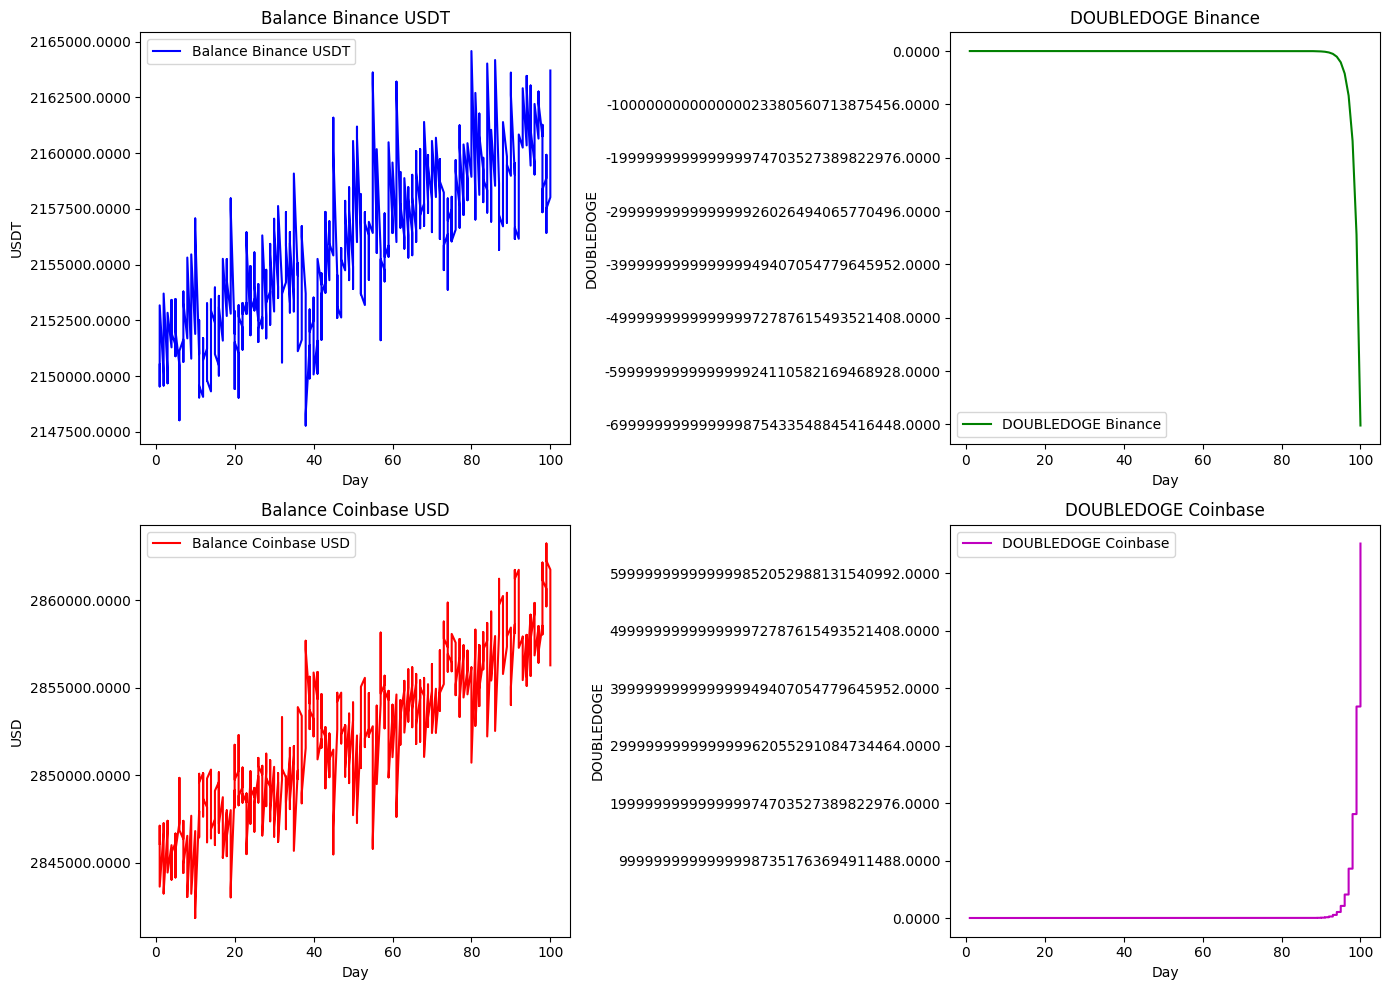

In [10]:

# Function to format y-axis to plain format
def format_axes(ax):
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.4f}'.format(x)))

# Plot the specified columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot balance_binance_usdt
axs[0, 0].plot(df['day'], df['balance_binance_usdt'], linestyle='-', color='b', label='Balance Binance USDT')
axs[0, 0].set_title('Balance Binance USDT')
axs[0, 0].set_xlabel('Day')
axs[0, 0].set_ylabel('USDT')
axs[0, 0].legend()
format_axes(axs[0, 0])

# Plot DOUBLEDOGE_binance
axs[0, 1].plot(df['day'], df['DOUBLEDOGE_binance'], linestyle='-', color='g', label='DOUBLEDOGE Binance')
axs[0, 1].set_title('DOUBLEDOGE Binance')
axs[0, 1].set_xlabel('Day')
axs[0, 1].set_ylabel('DOUBLEDOGE')
axs[0, 1].legend()
format_axes(axs[0, 1])

# Plot balance_coinbase_usd
axs[1, 0].plot(df['day'], df['balance_coinbase_usd'], linestyle='-', color='r', label='Balance Coinbase USD')
axs[1, 0].set_title('Balance Coinbase USD')
axs[1, 0].set_xlabel('Day')
axs[1, 0].set_ylabel('USD')
axs[1, 0].legend()
format_axes(axs[1, 0])

# Plot DOUBLEDOGE_coinbase
axs[1, 1].plot(df['day'], df['DOUBLEDOGE_coinbase'], linestyle='-', color='m', label='DOUBLEDOGE Coinbase')
axs[1, 1].set_title('DOUBLEDOGE Coinbase')
axs[1, 1].set_xlabel('Day')
axs[1, 1].set_ylabel('DOUBLEDOGE')
axs[1, 1].legend()
format_axes(axs[1, 1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
